In [1]:
import pandas as pd
import glob
import xarray as xr
import numpy as np
from statsmodels.stats.anova import AnovaRM 
from scipy import stats
from matplotlib import pyplot as plt
import pingouin as pg
import numpy as np
import seaborn as sns
import scipy

In [2]:
vn = ['fusiform-rh', 'fusiform-lh', 'lingual-lh', 'lingual-rh',
'cuneus-rh','cuneus-lh', 'lateraloccipital-rh', 'lateraloccipital-lh']

methods = ['gpdc','ddtf','psgp']

In [12]:
#Functions

def outlier_indices(data):
    q1 = np.percentile(data, 25, method='midpoint')
    q3 = np.percentile(data, 75, method='midpoint')
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr
    lower = q1 - 1.5 * iqr
    upper_outliers = np.where(data >= upper)[0]
    lower_outliers = np.where(data <= lower)[0]
    outlier_index_list = list(upper_outliers) + list(lower_outliers)
    
    return outlier_index_list

def remove_outliers(data):
    outliers_removed = []
    
    for i in range(0,len(data)):
        if i not in outlier_indices(data):
            outliers_removed.append(data[i])
            
    return outliers_removed

def bootstrap_ci(group1, group2):
    
    ####################################################
    #sample from pooled 1000 times
    n1 = len(group1)
    n2 = len(group2)
    
    bootstrap_sample1 = []
    bootstrap_sample2 = []
    
    for i in range(1000):
        sample1 = []
        sample2 = []
        index1 = np.random.choice(range(0,n1),n1,replace=True)
        index2 = np.random.choice(range(0,n2),n2,replace=True)
        sample1 = np.array(group1)[index1]
        sample2 = np.array(group2)[index2]
        bootstrap_sample1.append(sample1)
        bootstrap_sample2.append(sample2)
        
    diff_list = []
    for i in range(1000):
        mean1 = np.mean(bootstrap_sample1[i])
        mean2 = np.mean(bootstrap_sample2[i])
    
        diff = mean2 - mean1
        diff_list.append(diff)
    

    diff_list.sort()


    perc_025 = diff_list[24]
    perc_975 = diff_list[974]

    
    return perc_025, perc_975

In [4]:
def confint_95(data):

    bootstrap_samples = []

    for i in range(1000):
    #create 1000 bootstrap samples
        n = len(data)
        index = np.random.choice(range(0,n),n,replace=True)
        sample = np.array(data)[index]
        bootstrap_samples.append(sample)
    
    #calculate 1000 means
    means = []
    for sample in bootstrap_samples:
        mean = np.mean(sample)
        means.append(mean)

    #sort means list
    means.sort()
    
    #choose 25th value, choose 975th value
    perc_025 = means[24]
    perc_975 = means[974]

    
    return perc_025, perc_975

In [13]:
#assembling variance dictionaries

inter_variance_dict = {}
intra_variance_dict = {}

for method in methods: 
    subject_files = glob.glob(f'/work/srishyla/{method}/*_EC.nc')

    #intra
    
    mean_per_subject = []
    for file in subject_files:
        xarray = xr.open_dataarray(file)
        std2_list = []
        for sample in range(0,100):
            std = xarray.sel(bootstrap_samples=sample, region1=vn, region2=vn).values.std()
            std2_list.append(std**2)
        mean_per_subject.append(np.mean(std2_list))
    intra_variance_dict[method] = mean_per_subject
    
    #inter
    
    all_bootstraps = []  #list of 11200 arrays
    for file in subject_files:
        xarray = xr.open_dataarray(file)
        for sample in range(0,100):
            bootstrap = xarray.sel(bootstrap_samples=sample, region1=vn, region2=vn).values
            all_bootstraps.append(bootstrap)
    
    random_bootstraps = []
    for i in range(0,112):
        index = np.random.choice(range(0,11200),100,replace=False)
        sample = np.array(all_bootstraps)[index,:]
        random_bootstraps.append(sample)

    mean_per_bootstrap = []
    for sample in random_bootstraps:
        std_list = []
        for i in range(0,100):
            std = sample[i].std()
            std_list.append(std**2)
    
        mean_per_bootstrap.append(np.mean(std_list))
    
    inter_variance_dict[method] = mean_per_bootstrap

KeyboardInterrupt: 

In [6]:
#Remove outliers
for method in methods:
    inter_variance_dict[method] = remove_outliers(inter_variance_dict[method])
    intra_variance_dict[method] = remove_outliers(intra_variance_dict[method])

In [7]:
##CHECK SAMPLE SIZES OF DICTIONARIES
for method in methods:
    print(method, len(inter_variance_dict[method]))

coh 112
ciplv 112
imcoh 111
wpli2 107


In [8]:
## CHECK SAMPLE SIZES OF DICTIONARIES
for method in methods:
    print(method, len(intra_variance_dict[method]))

coh 111
ciplv 108
imcoh 107
wpli2 105


In [9]:
#calculating ratios
ratio_dict = {}
for method in methods:
    ratio_list = []
    for inter_variance,intra_variance in zip(inter_variance_dict[method],intra_variance_dict[method]):
        ratio = inter_variance / intra_variance
        ratio_list.append(ratio)
    ratio_dict[method] = ratio_list

In [11]:
#STATISTICAL TESTING FOR DIFFERENCE IN VARIANCE BETWEEN INTER-VARIANCE-DICTIONARIES AND INTRA-VARIANCE DICTIONARIES

In [12]:
#BOOTSTRAP T STATISTIC (UNEQUAL SAMPLES)

In [1]:
comparison_pairs = [('gpdc','psgp'), 
                    ('gpdc','ddtf'), 
                    ('psgp','ddtf')]

In [14]:
ci_dict = {}

for pair in comparison_pairs:
    method1 = pair[0]
    method2 = pair[1]

    ci_dict[pair] = bootstrap_ci(ratio_dict[method1], ratio_dict[method2])

In [15]:
print('ci_dict',ci_dict)

ci_dict {('coh', 'ciplv'): (0.1686464881014449, 0.45268756220253437), ('coh', 'imcoh'): (0.2762887381982624, 0.6532365050391844), ('coh', 'wpli2'): (2.347995796897207, 4.012999173058384), ('ciplv', 'imcoh'): (-0.07632928627033442, 0.3391172506927407), ('ciplv', 'wpli2'): (2.003211949835901, 3.7551765045951124), ('imcoh', 'wpli2'): (1.9061112952632076, 3.581013593378829)}


In [ ]:
#EXAMINING DISTRIBUTIONS TO UNDERSTAND SIGNIFICANCE

In [31]:
ratio_df = pd.DataFrame([ratio_dict['gpdc'], ratio_dict['ddtf'], ratio_dict['psgp']).transpose()

In [40]:
headers =  ['Coh', 'ciPLV', 'imCoh', 'dwPLI']
ratio_df.columns = headers

In [43]:
ratio_df_long = ratio_df.melt(var_name='Measures', value_name='Ratios')

In [58]:
ci_95 = []
for method in list(ratio_dict.keys()):
    lower_limit = confint_95(ratio_dict[method])[0]
    upper_limit = confint_95(ratio_dict[method])[1]
    err = upper_limit - lower_limit
    ci_95.append(err)

In [61]:
means = []
for method in list(ratio_dict.keys()):
    means.append(np.mean(ratio_dict[method]))

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (4,) and arg 1 with shape (1000,).

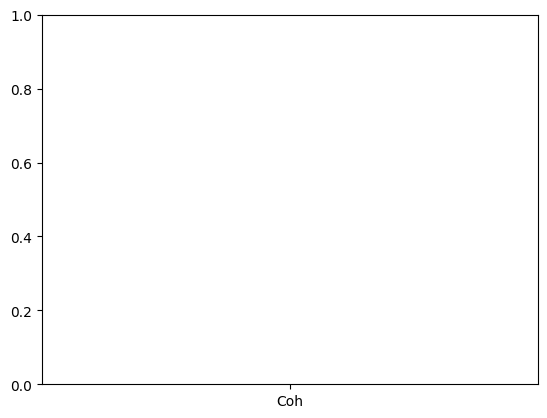

In [138]:
plt.bar(headers, means, color='gray')
plt.errorbar(headers, means, yerr=ci_95, linestyle="",ecolor='black')
plt.ylabel('Between-to-within variance ratio')